# Part 1: Network Training

## Step0: Import Package & Hyperparameter Configuration

In [11]:
"""
2025/02/03: 1.新增normDict計算 #!注意normDict是有先經過資料前處理計算的
            2.資料集中任意取n筆去訓練(n:自填數) 
            
"""

'\n2025/02/03: 1.新增normDict計算 #!注意normDict是有先經過資料前處理計算的\n            2.資料集中任意取n筆去訓練(n:自填數) \n            \n'

### Package

In [12]:
%reset -f

import os
import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

### Hyperparameter Config

In [13]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 3000
    BATCH_SIZE = 128
    LEARNING_RATE = 0.002  #論文提供
    LR_SCHEDULER_GAMMA = 0.99  #論文提供
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 500
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Material & Number of Data

In [14]:
material = "N87"
data_number = 5000

# 定義保存模型的路徑
model_save_dir = "./Model/"
os.makedirs(model_save_dir, exist_ok=True)  # 如果路徑不存在，創建路徑

# 定義模型保存檔名
model_save_path = os.path.join(model_save_dir, f"{material}.pt")

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1: Data processing and data loader generate 

In [15]:
# %% Preprocess data into a data loader
def get_dataloader(data_B, data_F, data_T, data_H, data_Pcv, n_init=16):
    """ #*(Date:250105)
    Process data and return DataLoader for training, validation, and testing.

    Parameters
    ----------
    data_B : np.array
        Magnetic flux density data.
    data_F : np.array
        Frequency data.
    data_T : np.array
        Temperature data.
    data_H : np.array
        Magnetic field strength data.
    data_Pcv : np.array
        Core loss data.
    norm : list
        Normalization parameters for the features.
    n_init : int
        Number of initial data points for magnetization.

    Returns
    -------
    train_loader, valid_loader, test_loader : DataLoader
        Dataloaders for training, validation, and testing sets.
    """

    # Data pre-process
    # 1. Down-sample to 128 points
    seq_length = 128
    cols = range(0, 1024, int(1024 / seq_length))  #range(start, stop, step)
    data_B = data_B[:, cols]
    data_H = data_H[:, cols]  #*  Add H Down-sample to 128 points (Date:241213)

    # 2. Add extra points for initial magnetization calculation
    data_length = seq_length + n_init
    data_B = np.hstack((data_B, data_B[:, :n_init]))
    data_H = np.hstack(
        (data_H, data_H[:, :n_init]))  #*(Date:241216) MMINN output似乎是128點
    #*(Date:250130) 原始MMINN H有包含n_init

    # 3. Format data into tensors  #*(Date:241216) seq_length=128, data_length=144
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # 原本在6. 因要先計算標準化故移至這
    dB = torch.diff(B, dim=1)
    dB = torch.cat((dB[:, 0:1], dB), dim=1)
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))

    # 4. Compute normalization parameters (均值 & 標準差)**
    norm = [
        [torch.mean(B).item(), torch.std(B).item()],  # 1. B (磁通密度)
        [torch.mean(H).item(), torch.std(H).item()],  # 2. H (磁場強度)
        [torch.mean(F).item(), torch.std(F).item()],  # 3. F (頻率，取 log10)
        [torch.mean(T).item(), torch.std(T).item()],  # 4. T (溫度)
        [torch.mean(dB_dt).item(),
         torch.std(dB_dt).item()],  # 5. dB/dt
        [torch.mean(Pcv).item(), torch.std(Pcv).item()]  # 6. Pv (核心損耗，取 log10)
    ]

    material_name = f"{material}"  # 可以改成你想要的材料名稱
    print(f'"{material_name}": [')
    for param in norm:
        print(f"    {param},")
    print("]")

    # 5. Data Normalization
    in_B = (B - norm[0][0]) / norm[0][1]
    out_H = (H - norm[1][0]) / norm[1][1]
    in_T = (T - norm[3][0]) / norm[3][1]
    in_F = (F - norm[2][0]) / norm[2][1]
    in_Pcv = (Pcv - norm[5][0]) / norm[5][1]

    # 6. Extra features

    in_dB = torch.diff(B, dim=1)
    in_dB = torch.cat((in_dB[:, 0:1], in_dB), dim=1)

    in_dB_dt = (dB_dt - norm[4][0]) / norm[4][1]

    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)

    s0 = get_operator_init(in_B[:, 0] - in_dB[:, 0], in_dB, max_B, min_B)

    # 7. Create dataloader to speed up data processing
    full_dataset = torch.utils.data.TensorDataset(
        torch.cat((in_B, in_dB, in_dB_dt), dim=2),  # B 部分（144 點）
        torch.cat((in_F, in_T, in_Pcv), dim=1),  # 輔助變量
        s0,  # 初始狀態
        out_H)

    # Split dataset into train, validation, and test sets (60:20:20)
    train_size = int(0.8 * len(full_dataset))
    valid_size = len(full_dataset) - train_size

    train_dataset, valid_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, valid_size],
        generator=torch.Generator().manual_seed(Config.SEED))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0,
                                               collate_fn=filter_input)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0,
                                               collate_fn=filter_input)

    return train_loader, valid_loader, norm


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=5,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, s0, target_H = zip(*batch)

    # 如果 inputs 是 tuple，先堆疊成張量
    inputs = torch.stack(inputs)  # B 的所有輸入部分（144 點）

    # 保留 in_B, in_dB, in_dB_dt 作為模型輸入
    inputs = inputs[:, :, :3]

    # 保留 features（包括 in_F 和 in_T）
    features = torch.stack(features)[:, :2]

    # 保留目標值 H
    target_H = torch.stack(target_H)[:, -128:, :]  # 只取最後 128 點

    s0 = torch.stack(s0)  # 初始狀態

    return inputs, features, s0, target_H


## Step2: Define Network Structure

In [ ]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt)
    - var_size: number of supplenmentary variables (1.F 2.T)        
    - output_size: number of outputs (1.H)
"""


class MMINet(nn.Module):
    def __init__(
            self,
            norm,  #*這裡改成從外部傳入 norm(250203)
            hidden_size=Config.HIDDEN_SIZE,
            operator_size=Config.OPERATOR_SIZE,
            input_size=3,
            var_size=2,
            output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = norm  #*這裡改成從外部傳入 norm(250203)

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + 2, 1)
        self.rnn2 = EddyCell(4, self.hidden_size, output_size)
        self.dnn2 = nn.Linear(self.hidden_size, 1)

        self.rnn2_hx = None

    def forward(self, x, var, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
          - var(batch,var_size): Supplementary inputs (1.F 2.T)
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # Initialize DNN2 input (1.B 2.dB/dt)
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        H = (output[:, n_init:, :])

        return H


class StopOperatorCell():
    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(5 / operator_size, 5, operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden

## Step3: Training the Model

### Load Dataset

In [17]:
# %%
def load_dataset(material, base_path="./Data/"):

    in_file1 = f"{base_path}{material}/B_Field.csv"
    in_file2 = f"{base_path}{material}/Frequency.csv"
    in_file3 = f"{base_path}{material}/Temperature.csv"
    in_file4 = f"{base_path}{material}/H_Field.csv"
    in_file5 = f"{base_path}{material}/Volumetric_Loss.csv"

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N by 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N by 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N by 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N by 1024
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N by 1

    # 隨機選取 1000 筆資料
    data_size = len(data_B)
    np.random.seed(Config.SEED)  # 設定隨機種子確保可復現
    indices = np.random.choice(data_size, data_number,
                               replace=False)  # 隨機選取 1000 筆

    data_B = data_B[indices]
    data_F = data_F[indices]
    data_T = data_T[indices]
    data_H = data_H[indices]
    data_Pcv = data_Pcv[indices]

    return data_B, data_F, data_T, data_H, data_Pcv


### Train Code

In [18]:
# %%
def train_model(norm, train_loader, valid_loader):

    model = MMINet(norm=norm).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

    best_val_loss = float('inf')
    patience_counter = 0

    # 定義保存路徑
    model_save_path = os.path.join("./Model/", f"{material}.pt")

    # **新增 Loss 記錄**
    train_losses = []
    val_losses = []

    for epoch in range(Config.NUM_EPOCHS):
        model.train()
        train_loss = 0

        for inputs, features, s0, target_H in train_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, features, s0)  # 模型的輸出
            loss = criterion(outputs, target_H)  # 使用真實的 H(t) 計算損失
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # **記錄 Train Loss**

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for inputs, features, s0, target_H in valid_loader:
                inputs, features, s0, target_H = inputs.to(
                    device), features.to(device), s0.to(device), target_H.to(
                        device)
                outputs = model(inputs, features, s0)
                loss = criterion(outputs, target_H)
                val_loss += loss.item()

        val_loss /= len(valid_loader)
        val_losses.append(val_loss)  # **記錄 Validation Loss**

        print(
            f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}"
        )

        # ======================================================繪製訓練情況======================================================
        plot_interval = 500
        if (epoch + 1) % plot_interval == 0:
            outputs = outputs[:3].detach().cpu().numpy()
            targets = target_H[:3].detach().cpu().numpy()

            # 設定圖表
            plt.figure(figsize=(12, 6))

            for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
                plt.plot(outputs[i, :, 0],
                         label=f"Pred: Sample {i+1}",
                         linestyle='--',
                         marker='o')
                plt.plot(targets[i, :, 0],
                         label=f"Target: Sample {i+1}",
                         linestyle='-',
                         marker='x')

            # 添加標題和標籤
            plt.title(f"Compare - Epoch {epoch + 1}", fontsize=16)
            plt.xlabel("Index", fontsize=14)
            plt.ylabel("Value", fontsize=14)
            plt.legend(loc="upper right", fontsize=12)
            plt.grid(alpha=0.5)

            # 顯示圖表
            plt.show()
        # ======================================================繪製訓練情況= END ======================================================

        # ======================================================Early stop======================================================
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)  # 保存最佳模型
            print(
                f"Saving model at epoch {epoch+1} with validation loss {val_loss:.6f}..."
            )
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

        # ======================================================Early stop======================================================

    print(f"Training complete. Best model saved at {model_save_path}.")

    # ==============================繪製 Train Loss 與 Validation Loss 圖==============================
    plt.figure(figsize=(10, 5))
    plt.plot(
        range(1,
              len(train_losses) + 1),
        train_losses,
        label="Train Loss",
    )
    plt.plot(range(1,
                   len(val_losses) + 1),
             val_losses,
             label="Validation Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()
    # ==============================繪製 Train Loss 與 Validation Loss 圖 END==============================

    # ===================================使用最佳模型來產生驗證結果=============================
    model.load_state_dict(torch.load(model_save_path))  # 載入最佳模型
    model.eval()

    with torch.no_grad():
        for inputs, features, s0, target_H in valid_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            outputs = model(inputs, features, s0)  # 使用最佳模型產生預測值
            outputs = outputs[:3].detach().cpu().numpy()
            targets = target_H[:3].detach().cpu().numpy()
            break  # 只使用一批驗證數據進行可視化

    # **繪製最佳模型的輸出與 Ground Truth 比較**
    plt.figure(figsize=(12, 6))

    for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
        plt.plot(outputs[i, :, 0],
                 label=f"Pred: Sample {i+1}",
                 linestyle='--',
                 marker='o')
        plt.plot(targets[i, :, 0],
                 label=f"Target: Sample {i+1}",
                 linestyle='-',
                 marker='x')

    plt.title(f"Best Model - Predicted vs Target", fontsize=16)
    plt.xlabel("Index", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()

    # ===================================使用最佳模型來產生驗證結果 END=============================

In [19]:
# 驗證輸入shape
# net = MMINet(Material=material).to(device)
# for inputs, features, s0 in train_loader:
#     print(f"inputs shape: {inputs.shape}")  # 包括 in_B, in_dB, in_dB_dt
#     print(f"features shape: {features.shape}")  # 包括 in_F, in_T
#     print(f"s0 shape: {s0.shape}")  # 初始化狀態向量
#     break

# 驗證輸出shape
# net = MMINet(Material=material).to(device)
# for inputs, features, s0 in train_loader:
#     # 提取輸入數據
#     inputs = inputs.to(device)  # in_B, in_dB, in_dB_dt
#     features = features.to(device)  # in_F, in_T
#     s0 = s0.to(device)  # 初始狀態向量

#     # 將數據傳入模型
#     outputs = net(inputs, features, s0)

#     # 打印輸出形狀與樣本數據
#     print(f"outputs shape: {outputs.shape}")
#     print(f"outputs data: {outputs[0]}")  # 打印第一個樣本的輸出波形數據
#     break


### Start Train!!!

"N87": [
    [-0.0039005703292787075, 0.060377106070518494],
    [-0.5195177793502808, 11.593074798583984],
    [5.180987358093262, 0.2678092122077942],
    [58.85100173950195, 24.114748001098633],
    [0.24289657175540924, 2.2880825996398926],
    [4.625202178955078, 0.8005720973014832],
]
Epoch 1, Train Loss: 0.849474, Validation Loss: 0.601206
Saving model at epoch 1 with validation loss 0.601206...
Epoch 2, Train Loss: 0.374956, Validation Loss: 0.134751
Saving model at epoch 2 with validation loss 0.134751...
Epoch 3, Train Loss: 0.098620, Validation Loss: 0.076957
Saving model at epoch 3 with validation loss 0.076957...
Epoch 4, Train Loss: 0.069072, Validation Loss: 0.058458
Saving model at epoch 4 with validation loss 0.058458...
Epoch 5, Train Loss: 0.054430, Validation Loss: 0.048371
Saving model at epoch 5 with validation loss 0.048371...
Epoch 6, Train Loss: 0.046155, Validation Loss: 0.041795
Saving model at epoch 6 with validation loss 0.041795...
Epoch 7, Train Loss: 0.0

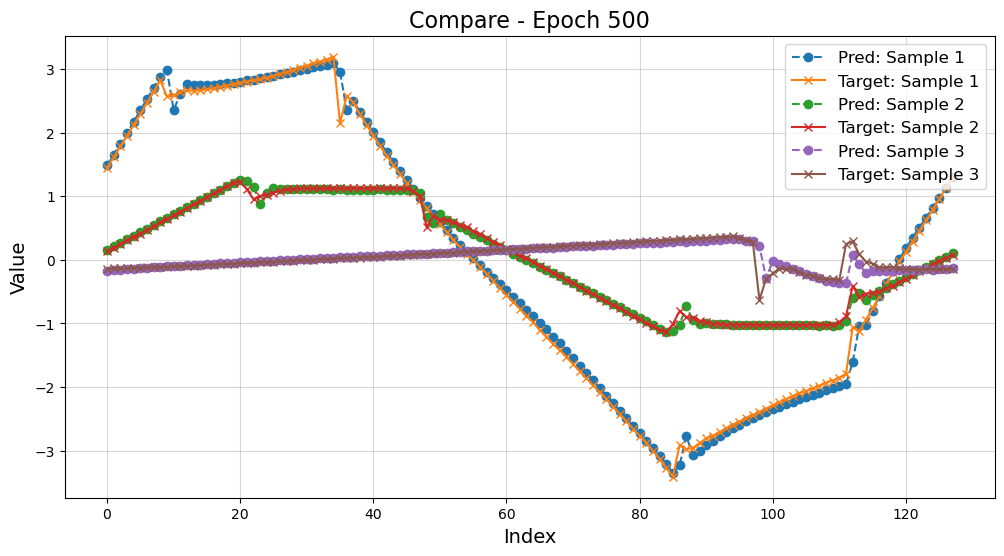

Epoch 501, Train Loss: 0.006558, Validation Loss: 0.013001
Epoch 502, Train Loss: 0.007185, Validation Loss: 0.012103
Epoch 503, Train Loss: 0.006608, Validation Loss: 0.011923
Epoch 504, Train Loss: 0.006567, Validation Loss: 0.012019
Epoch 505, Train Loss: 0.006799, Validation Loss: 0.011992
Epoch 506, Train Loss: 0.006877, Validation Loss: 0.012619
Epoch 507, Train Loss: 0.007296, Validation Loss: 0.012833
Epoch 508, Train Loss: 0.006950, Validation Loss: 0.011891
Epoch 509, Train Loss: 0.006690, Validation Loss: 0.013235
Epoch 510, Train Loss: 0.007201, Validation Loss: 0.012956
Epoch 511, Train Loss: 0.006617, Validation Loss: 0.012519
Epoch 512, Train Loss: 0.006731, Validation Loss: 0.011946
Epoch 513, Train Loss: 0.006813, Validation Loss: 0.012348
Epoch 514, Train Loss: 0.006839, Validation Loss: 0.012830
Epoch 515, Train Loss: 0.006910, Validation Loss: 0.012257
Epoch 516, Train Loss: 0.006577, Validation Loss: 0.012103
Epoch 517, Train Loss: 0.006865, Validation Loss: 0.0124

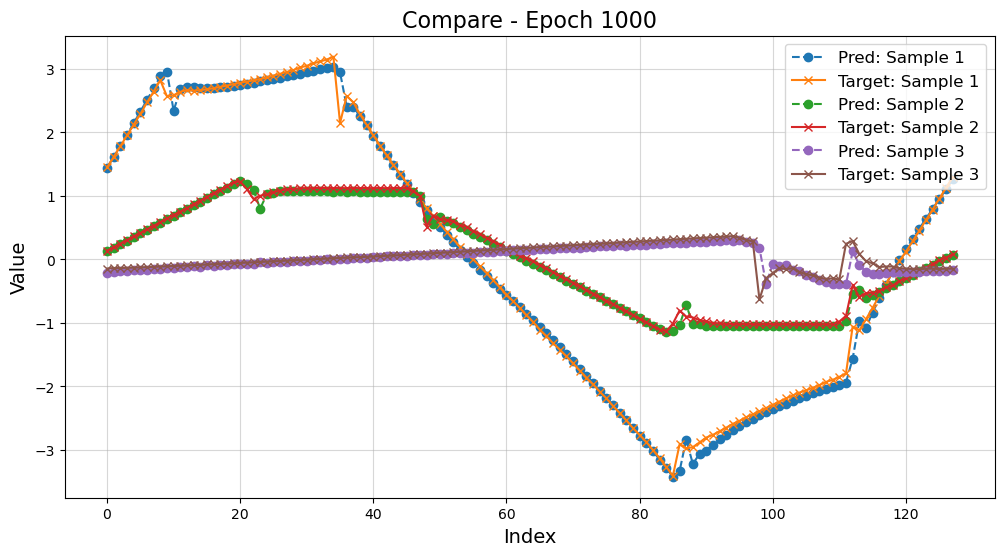

Epoch 1001, Train Loss: 0.006159, Validation Loss: 0.011830
Epoch 1002, Train Loss: 0.006210, Validation Loss: 0.012065
Epoch 1003, Train Loss: 0.006172, Validation Loss: 0.012594
Epoch 1004, Train Loss: 0.006356, Validation Loss: 0.012080
Epoch 1005, Train Loss: 0.006241, Validation Loss: 0.011610
Epoch 1006, Train Loss: 0.006091, Validation Loss: 0.011860
Epoch 1007, Train Loss: 0.006119, Validation Loss: 0.011513
Epoch 1008, Train Loss: 0.005969, Validation Loss: 0.011452
Epoch 1009, Train Loss: 0.006115, Validation Loss: 0.011787
Epoch 1010, Train Loss: 0.006343, Validation Loss: 0.012582
Epoch 1011, Train Loss: 0.006247, Validation Loss: 0.012446
Epoch 1012, Train Loss: 0.006155, Validation Loss: 0.011625
Epoch 1013, Train Loss: 0.005901, Validation Loss: 0.011531
Epoch 1014, Train Loss: 0.006099, Validation Loss: 0.012047
Epoch 1015, Train Loss: 0.006030, Validation Loss: 0.012195
Epoch 1016, Train Loss: 0.006184, Validation Loss: 0.011638
Epoch 1017, Train Loss: 0.006063, Valida

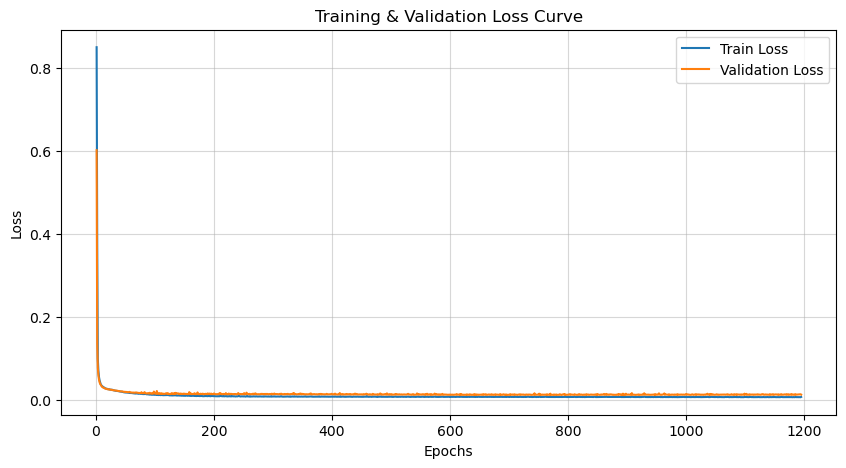

C:\Users\USER\AppData\Local\Temp\ipykernel_7548\1888580014.py:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))  # 載入最佳模型

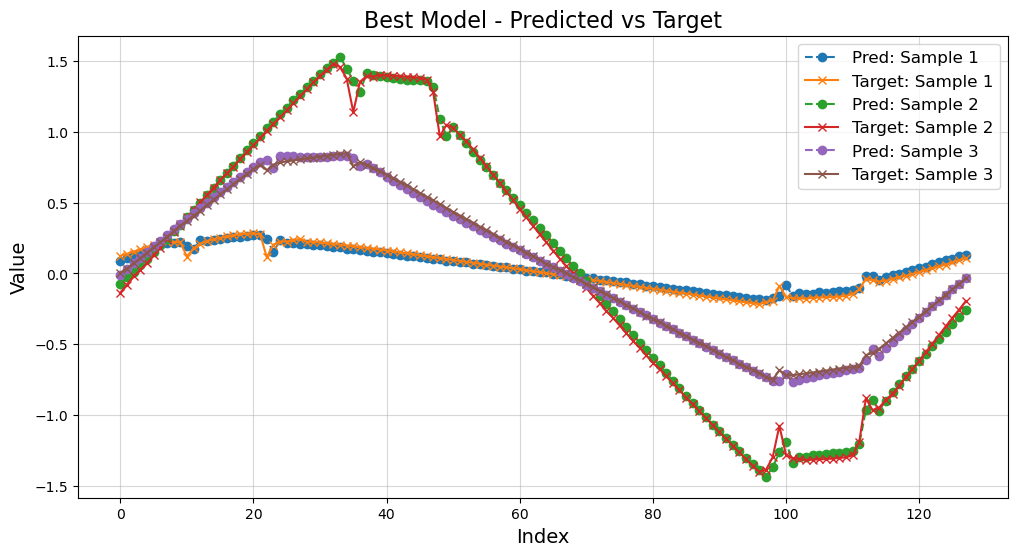

In [20]:
if __name__ == "__main__":

    data_B, data_F, data_T, data_H, data_Pcv = load_dataset(material)
    # norm_values = calculate_norm(data_B, data_H, data_F, data_T, data_Pcv)
    # print(norm_values)  # 輸出該材料的 (均值, 標準差)

    train_loader, valid_loader, norm = get_dataloader(data_B, data_F, data_T,
                                                      data_H, data_Pcv)

    train_model(norm, train_loader, valid_loader)